In [1]:
# 0. 사용할 패키지 불러오기
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

from math import sqrt

np.random.seed(5)


# 1. 데이터셋 생성하기
signal_data = pd.read_csv('price_tomato1_S.csv', engine='python', encoding='ms949')
data = signal_data.values
retail_price = data

#std = np.std(df[‘retail_price’].values)

#create_ dataset
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 1:])
        dataY.append(signal_data[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

look_back = 7

#2. 데이터셋 분할
X, Y = create_dataset(data, look_back)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
Y

array([4300., 4300., 4435., ..., 4900., 5160., 5150.])

In [3]:
#기술통계
train_stats = signal_data.describe()
train_stats.pop("date")
train_stats = train_stats.transpose()

train_stats


,count,mean,std,min,25%,50%,75%,max
mean(°C),1428.0,13.590126,10.888134,-14.8,4.375,15.0,23.00,33.7
prep(mm),1428.0,3.065616,11.846932,0.0,0.000,0.0,0.20,144.5
humidity(%),1428.0,57.811975,14.807831,21.8,46.800,57.8,67.65,97.0
in,1428.0,17020.515406,18735.705225,0.0,1318.500,12198.0,25805.25,136936.0
week(code),1428.0,0.782913,0.412407,0.0,1.000,1.0,1.00,1.0
whole_price,1428.0,26810.224090,8658.011133,10000.0,20000.000,26000.0,32250.00,55000.0
retail_price,1428.0,4339.872549,1317.539493,2259.0,3254.000,4300.0,4943.00,9882.0


In [4]:
rtp = retail_price[:,-1]
print(rtp)

[4125. 4125. 4125. ... 4900. 5160. 5150.]


In [5]:
std = np.std(rtp)
print(std)

1317.0780884363542


### create dataset을 수행한 뒤 데이터 분할

In [6]:
signal_data.shape

(1428, 8)

In [7]:
# 데이터셋 생성
x_train = X[0:850,]
y_train = Y[0:850,] 

x_val = X[850:1100]
y_val = Y[850:1100]

x_test = X[1100:,]
y_test = Y[1100:,]
y_test_var = y_test


In [8]:
# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(7, 7), activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(1))


#3.1. 모델 아키텍쳐 살펴보기
# model.summary()

# 4. 모델 학습과정 설정하기
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [9]:
#5.모델 학습시키기
#5.1. Early Stopping
callbacks_list = [
    EarlyStopping(
    monitor='val_loss',
    patience=20 ,
    ),
#     ModelCheckpoint(
#     filepath='multi_model.h5',
#     monitor='val_loss',
#     save_best_only = True,
#     )
]

hist = model.fit(x_train, y_train, epochs=500, batch_size=16, callbacks=callbacks_list, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 850 samples, validate on 250 samples
Epoch 1/500





850/850 [==============================] - 4s 5ms/step - loss: 17105293.2753 - mean_absolute_error: 3745.8872 - val_loss: 20242109.5440 - val_mean_absolute_error: 3779.0686
Epoch 2/500
850/850 [==============================] - 1s 1ms/step - loss: 11776487.4729 - mean_absolute_error: 3017.6929 - val_loss: 15487243.8400 - val_mean_absolute_error: 3178.0078
Epoch 3/500
850/850 [==============================] - 1s 1ms/step - loss: 8018652.2153 - mean_absolute_error: 2403.3073 - val_loss: 15579497.3600 - val_mean_absolute_error: 3263.2693
Epoch 4/500
850/850 [==============================] - 1s 1ms/step - loss: 7628852.5835 - mean_absolute_error: 2262.7306 - val_loss: 10563705.5680 - val_mean_absolute_error: 2550.2956
Epoch 5/500
850/850 [==============================] - 1s 1ms/step - loss: 4594549.5000 - mean_absolute_error: 164

In [10]:
# 6. 모델 평가하기
scores = model.evaluate(x_test, y_test)

print("%s: %.2f" %(model.metrics_names[1], scores[1]))

321/321 [==============================] - 0s 180us/step
mean_absolute_error: 602.86


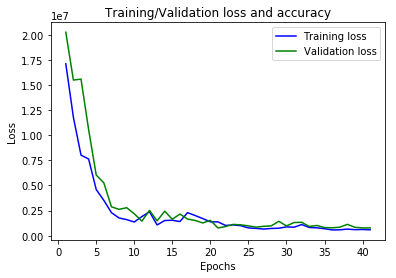

In [11]:
#6.1. epoch, loss 그래프
loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')

plt.title('Training/Validation loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# 6.2. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  [557817.5601470588, 563.0589803538603]
Validataion Score:  [778706.47375, 679.9086362304688]
Test Score:  [588184.6553251557, 602.8570142133956]


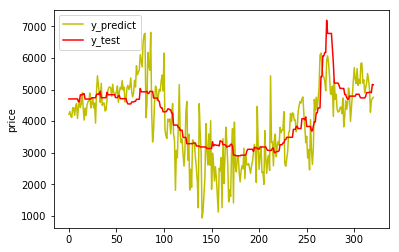

In [13]:
def show_diff(y_predict, y_label, y_test, y_test_label, y_value):

    fig, predict_ax=plt.subplots()

    predict_ax.plot(y_predict, 'y', label=y_label)

    predict_ax.plot(y_test, 'r', label=y_test_label)

    predict_ax.set_ylabel(y_value)

    predict_ax.legend(loc = 'upper left')

    plt.show()
    
#7 예측하기

y_predict = model.predict(x_test).flatten()

show_diff(y_predict, 'y_predict', y_test, 'y_test', 'price')

In [15]:
# 데이터 저장
df = pd.DataFrame(y_predict)
df.insert(0,'y_test',y_test_var)
df = df.rename(columns = {0: 'y_predict'})
df.to_csv('predict_tomato2.csv', index=False)

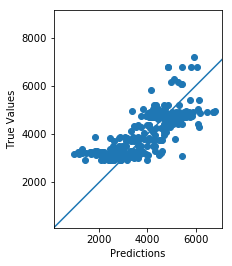

In [21]:

# test_predictions = y_test

# plt.scatter(y_test, y_predict)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([1000,plt.xlim()[1]])
# plt.ylim([1000,plt.ylim()[1]])
# _ = plt.plot([-100000, 100000], [-100000, 100000])

test_predictions = y_test

plt.scatter(y_predict, y_test)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([-10000, 10000], [-10000, 10000])


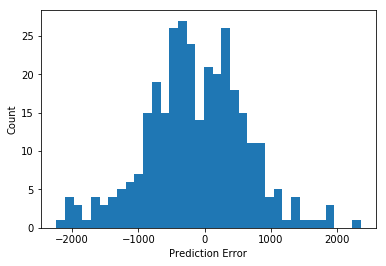

In [17]:
#오차의 분포
error = y_predict - y_test
plt.hist(error, bins = 35)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [18]:
rmse = sqrt(mean_squared_error(y_predict,y_test))
print("RMSE: {:.2f}".format(rmse))

RMSE: 766.93


In [19]:
print("STD: {:.2f}".format(std))

STD: 1317.08
